# Симуляция AA тестов

В наличии данные АА-теста с '2023-04-24' по '2023-04-30'. Нужно сделать симуляцию, как будто проведено 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

TO DO:

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [1]:
#импорт библиотек
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandahouse as ph
#делает хеш
import hashlib
from scipy import stats

In [2]:
#коннект к БД
connection = {
    'host': '***',
    'password': '***',
    'user': '***',
    'database': '***'
}

In [3]:
#запрос к БД
query = '''
SELECT exp_group,
       user_id,
       countIf(action = 'like') likes,
       countIf(action = 'view') views,
       likes/views ctr
FROM simulator_20230520.feed_actions
WHERE time::DATE BETWEEN '2023-04-24' AND '2023-04-30' AND exp_group in [2,3]
GROUP BY exp_group, user_id
'''

In [4]:
# присваивание полученных данных датафрейму
df = ph.read_clickhouse(query, connection=connection)

In [5]:
#чек
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


# 1 Построение гистограммы распределения 10000 p-values

In [6]:
#расчёт 10 000 p value
pvalue_list = []
for i in range(10000):
    pvalue_list.append(stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500), df[df.exp_group == 3].ctr.sample(500),equal_var=False).pvalue)  

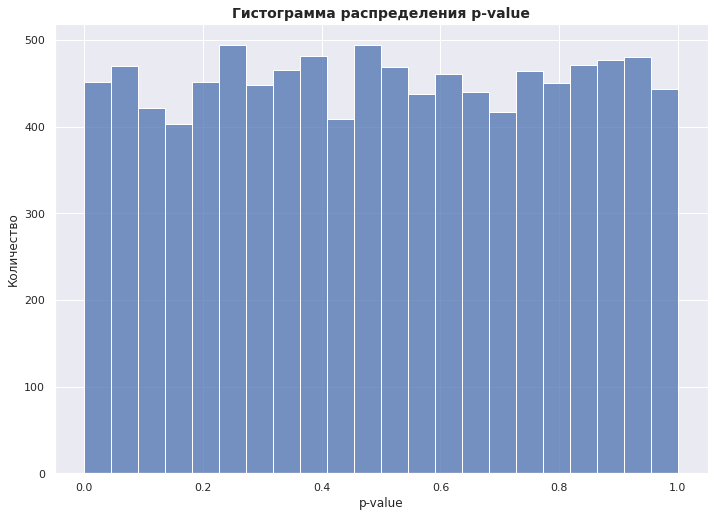

In [16]:
#гистограмма распределения p value
sns.histplot(data=pvalue_list)
plt.xlabel('p-value')
plt.ylabel('Количество')
plt.title('Гистограмма распределения p-value', fontweight='bold', fontsize=14)
plt.show()

# Вывод

Распределение p value близкое к равномерному, следовательно вероятность получить любое значение p value равновероятна.

# 2 Расчёт доли p values оказавшегося меньше либо равным 0.05

In [11]:
#абсолютное значение p значения < = 0.05
count = 0
for i in pvalue_list:
    if i <= 0.05:
        count += 1
count

493

In [12]:
#доля прокрашенных от общего количества 
round(count / len(pvalue_list) * 100, 2)

4.93

# Вывод

В 4.93% случаев p значение меньше 0,05. Т.е. при множественном сравнении гипотез приблизительно в 5% случаев есть шанс отвергнуть нулевую гипотезу даже при том, что в выборках статистически значимых различий нет.

# 3 Оценка результатов АА теста и корректности работы системы сплитования

In [13]:
#проверка корректности разбиения на группы
df.groupby('exp_group')['user_id'].count().to_frame().reset_index()

,exp_group,user_id
0,2,8480
1,3,8569


Количество пользователей в группах для АА теста сопоставимо.

In [14]:
#проверка пересечения пользователей
users_in_two = df.groupby('user_id').agg({'exp_group': 'nunique'}).query('exp_group > 1')
users_in_two.count()

exp_group    0
dtype: int64

Пользователи в группах не пересекаются.

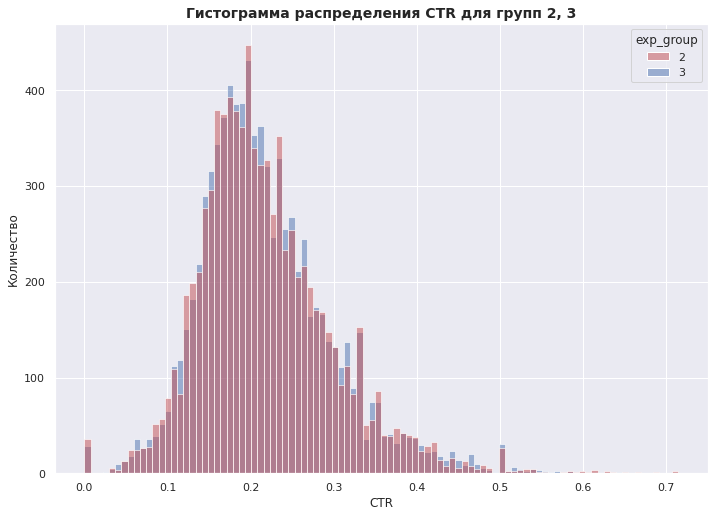

In [15]:
#визуализация распределения ctr в группах
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data =df, x='ctr', hue='exp_group', palette = ['r', 'b'], alpha=0.5, kde=False)
plt.xlabel('CTR')
plt.ylabel('Количество')
plt.title('Гистограмма распределения CTR для групп 2, 3', fontweight='bold', fontsize=14)
plt.show()

Исходя из графиков, можно сделать вывод о сопоставимости значений в группах.

Формирование нулевой и альтернативной гипотез:

Первая нулевая гипотеза H0 - Средние значения CTR в группах не различаются.

Первая альтернативная гипотеза H1 - Средние значения CTR в группах различаются.

In [17]:
#t test 
stat, p = stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var=False)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Принимаем нулевую гипотезу: выборки не различаются')
else:
    print('Отвергаем нулевую гипотезу: выборки различаются')

Statistics=-0.739, p=0.460
Принимаем нулевую гипотезу: выборки не различаются


# Вывод

С помощью t теста было выявлено, что различия по показателю CTR не имеют статистически значимой разницы. Система сплитования работает корректно, при многократном извлечении подвыборок, только в  4.69% случаев p значение меньше 0,05.